# Analysis of Otx-a SEL-seq data from Farley et al. (2015)
This dataset represents SEL-seq data generated by first constructing a dictionary of unique barcode tag-enhancer pairs by allowing 2 bp mismatches in the ~69 bp enhancers to buffer the sequencing mistakes. If more than one barcode tag was associated with a single enhancer the maximum reads between these tags were used. Barcoded tags that were attached to multiple enhancers were removed. The resulting dictionary contains 2,534,802 enhancers that are uniquely mapped to one or more barcode tags. 2 biological replicates were used in this experiment and the reads per million total reads (RPM) was used for each tag. In total 163,708 enhancers were detected by RNA-seq and 21,799 of them were defined as active enhancers by RPM ≥ 4 in either of the 2 replicates.

![farley15](images/farley15.jpeg)

In [17]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

# Python imports for analysis
import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/farley15"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/farley15"
eu.settings.dl_num_workers = 0
eu.settings.batch_size = 2048

0.1.0


# Dataloading

In [18]:
# Load the dataset from the module
sdata = eu.datasets.farley15()
sdata

Dataset farley15 farley2015_seqs.csv has already been dowloaded.
Dataset farley15 farley2015_seqs_annot.csv has already been dowloaded.


SeqData object with = 163708 seqs
seqs = (163708,)
names = (163708,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'Barcode', 'Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)'
pos_annot: None
seqsm: None
uns: None

# Preprocessing

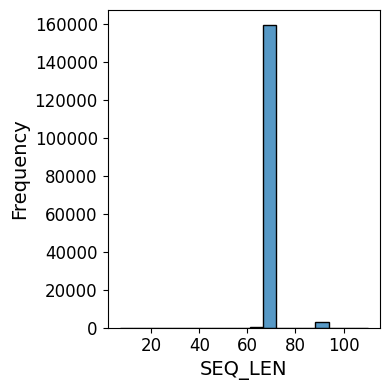

In [19]:
# Get and plot the distrubution on sequence length 
sdata["SEQ_LEN"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(sdata, keys="SEQ_LEN", orient="h")

In [20]:
# Keep only the sequences with length = 69 and add reverse complement, ohe and training labels
sdata_processed = sdata[sdata["SEQ_LEN"] == 69]
eu.pp.prepare_data(sdata_processed)
sdata_processed

  0%|          | 0/3 [00:00<?, ?it/s]

SeqData object modified:
	rev_seqs: None -> 151810 rev_seqs added
	ohe_seqs: None -> 151810 ohe_seqs added
	ohe_rev_seqs: None -> 151810 ohe_rev_seqs added
    seqs_annot:
        + TRAIN


SeqData object with = 151810 seqs
seqs = (151810,)
names = (151810,)
rev_seqs = (151810,)
ohe_seqs = (151810, 69, 4)
ohe_rev_seqs = (151810, 69, 4)
seqs_annot: 'Barcode', 'Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)', 'SEQ_LEN', 'TRAIN'
pos_annot: None
seqsm: None
uns: None

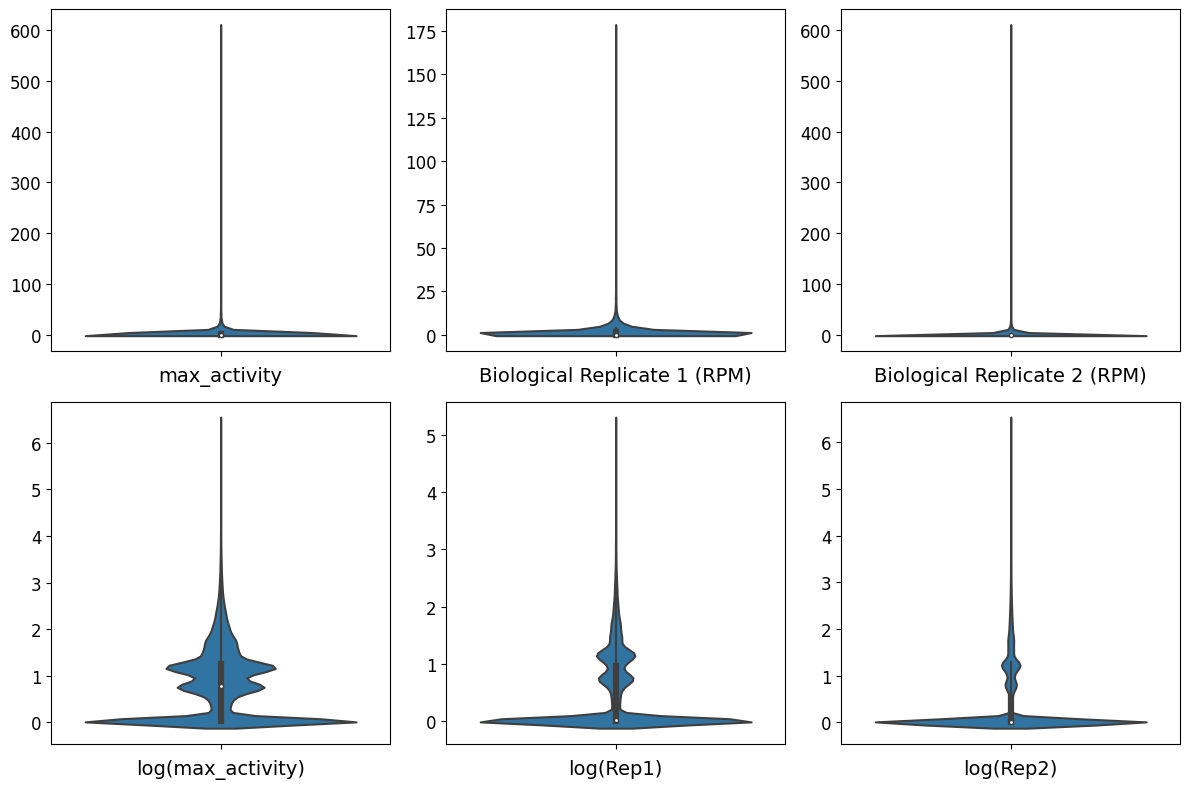

In [21]:
# Log normalize the labels and add a column for taking the max of the two replicate RPMs
sdata_processed["max_activity"] = sdata_processed.seqs_annot[["Biological Replicate 1 (RPM)", "Biological Replicate 2 (RPM)"]].max(axis=1)
sdata_processed.seqs_annot["log(Rep1)"] = np.log(sdata_processed["Biological Replicate 1 (RPM)"]+1)
sdata_processed.seqs_annot["log(Rep2)"] = np.log(sdata_processed["Biological Replicate 2 (RPM)"]+1)
sdata_processed.seqs_annot["log(max_activity)"] = np.log(sdata_processed["max_activity"]+1)
eu.pl.violinplot(sdata_processed, keys=["max_activity", "Biological Replicate 1 (RPM)", "Biological Replicate 2 (RPM)", "log(max_activity)", "log(Rep1)", "log(Rep2)"])

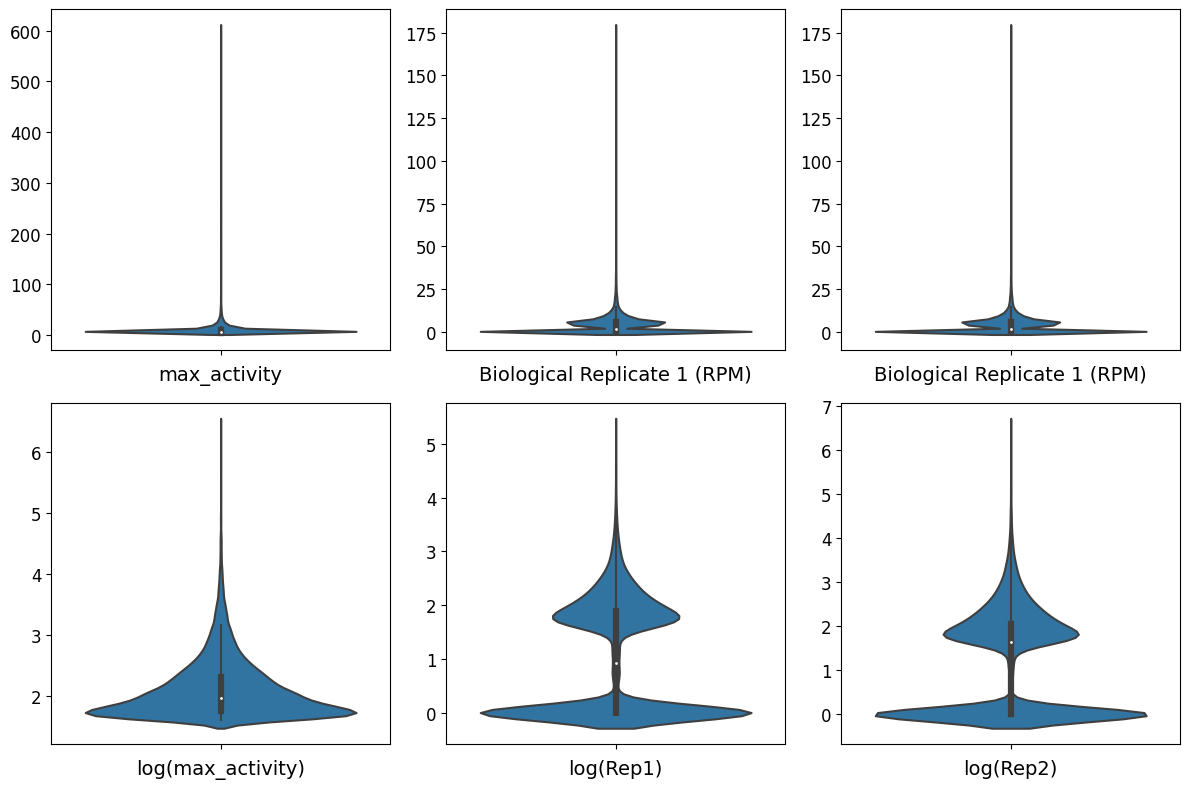

In [15]:
# Subset down to sequences with a a replicate with at least 4 RPM (wild-type Otx-a RPM)
sdata_subset = sdata_processed[sdata_processed["max_activity"] >= 4]
eu.pl.violinplot(sdata_subset, keys=["max_activity", "Biological Replicate 1 (RPM)", "Biological Replicate 1 (RPM)", "log(max_activity)", "log(Rep1)", "log(Rep2)"])

SeqData object modified:
    seqs_annot:
        + log(max_activity)_SCALED


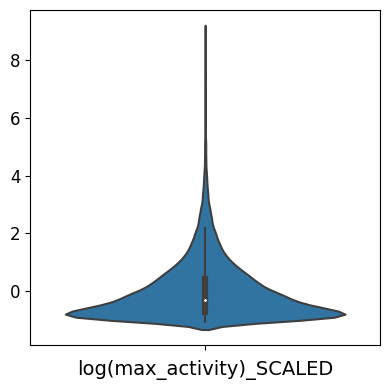

In [22]:
# Create a scaled version of the normalized activity
eu.pp.scale_targets(sdata_subset, "log(max_activity)")
eu.pl.violinplot(sdata_subset, keys="log(max_activity)_SCALED")

In [23]:
sdata_subset

SeqData object with = 20585 seqs
seqs = (20585,)
names = (20585,)
rev_seqs = (20585,)
ohe_seqs = (20585, 69, 4)
ohe_rev_seqs = (20585, 69, 4)
seqs_annot: 'Barcode', 'Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)', 'SEQ_LEN', 'TRAIN', 'max_activity', 'log(Rep1)', 'log(Rep2)', 'log(max_activity)', 'log(max_activity)_SCALED'
pos_annot: None
seqsm: None
uns: None

# Training

## >= 4 RPM w/ MSE loss on log transformed, scaled data

In [27]:
# Instantiate a simple CNN that 
model = eu.models.load_config("CNN", "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/farley15/ssCNN_reg.yaml")
eu.models.base.init_weights(model)

In [28]:
model.loss_fxn

<function torch.nn.functional.poisson_nll_loss(input: torch.Tensor, target: torch.Tensor, log_input: bool = True, full: bool = False, size_average: Union[bool, NoneType] = None, eps: float = 1e-08, reduce: Union[bool, NoneType] = None, reduction: str = 'mean') -> torch.Tensor>

In [29]:
# Train the model for 100 epochs
eu.train.fit(
    model=model, 
    sdata=sdata_subset, 
    gpus=1, 
    target="log(max_activity)",
    train_key="TRAIN",
    epochs=100,
    version="test_poisson_NLL"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 12.4 K
2 | fcnet     | BasicFullyConnectedModule | 1.1 M 
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)


No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.898


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.853


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.679


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.604


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.593


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.580


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.546


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.546. Signaling Trainer to stop.


In [33]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
tm_r2score = R2Score()
print(tm_r2score(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.r2_score(y_true, y_pred))

sdata_train = sdata_subset[train_idx]
sdata_val = sdata_subset[val_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(tm_r2score(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.r2_score(uno_x, dos_x))

tensor(0.9486)
0.9486081370449679
tensor(-122.3700)
-0.4080568562045297


In [34]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
print(model.loss_fxn(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.mean_squared_error(y_true, y_pred))

sdata_train = sdata_subset[train_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(model.loss_fxn(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.mean_squared_error(uno_x, dos_x))

tensor(733.5074)
0.375
tensor(3.1943, dtype=torch.float64)
1.4080568562045297


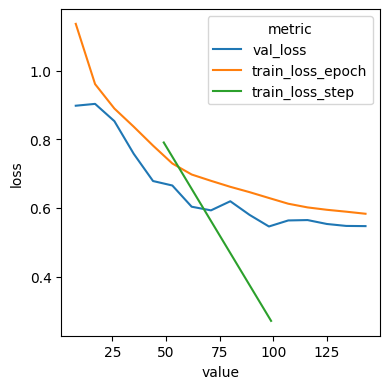

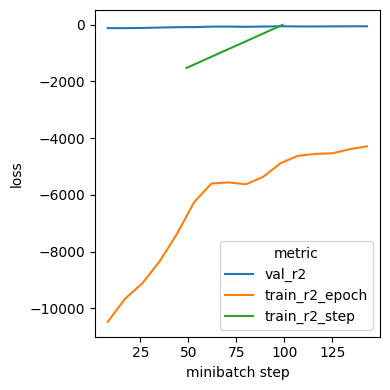

In [30]:
# Output training summary
eu.pl.training_summary("/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/farley15/ssCNN_regression/test_poisson_NLL/", metrics="r2")

# Evaluation

In [31]:
# Get train and validation predictions
eu.predict.train_val_predictions(
    model, 
    sdata=sdata_subset, 
    target="log(max_activity)_SCALED",
    train_key="TRAIN",
    version="test0"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + log(max_activity)_SCALED_PREDICTIONS


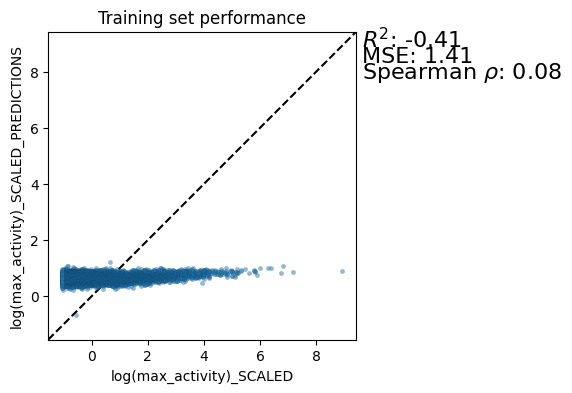

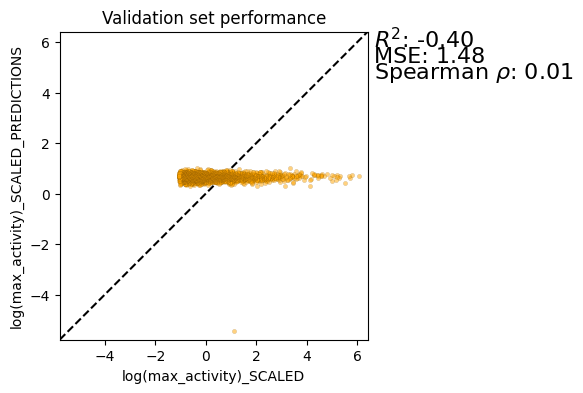

In [32]:
# Plot the performance scatterplot on the training and validation set
val_idx = np.where(sdata_subset["TRAIN"] == False)[0]
train_idx = np.where(sdata_subset["TRAIN"] == True)[0]
eu.pl.performance_scatter(
    sdata_subset, 
    seq_idx=train_idx, 
    target="log(max_activity)_SCALED", 
    prediction="log(max_activity)_SCALED_PREDICTIONS",
    title="Training set performance",
    alpha=0.5
)
eu.pl.performance_scatter(
    sdata_subset, 
    seq_idx=val_idx, 
    target="log(max_activity)_SCALED", 
    prediction="log(max_activity)_SCALED_PREDICTIONS",
    title="Validation set performance",
    color="orange",
    alpha=0.5
)

# Interpret 

In [134]:
eu.interpret.feature_attribution(model, sdata_subset)

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/4 [00:00<?, ?it/s]

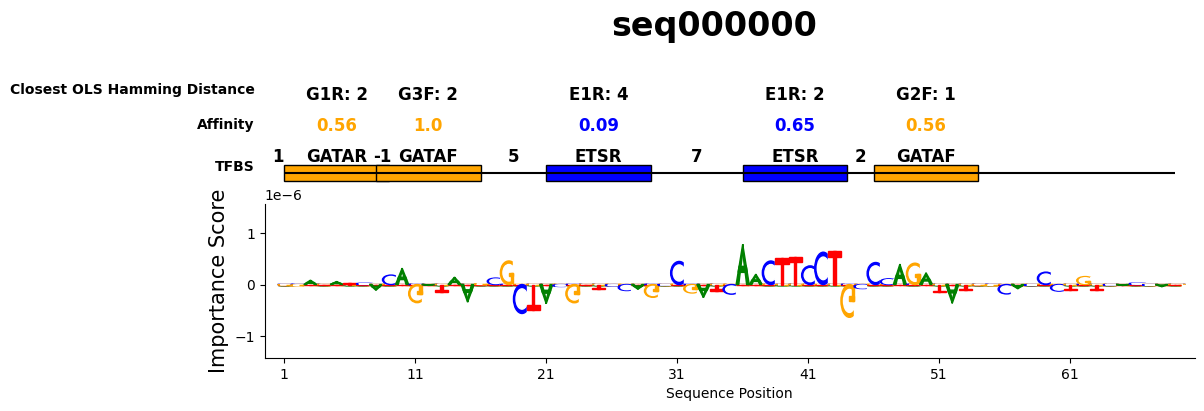

In [138]:
eu.pl.otx_seq(sdata_subset, seq_id=sdata_subset.names[0], uns_key="InputXGradient_imps")

In [149]:
eu.interpret.generate_pfms(model, sdata_subset)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/4 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/32 [00:00<?, ?it/s]

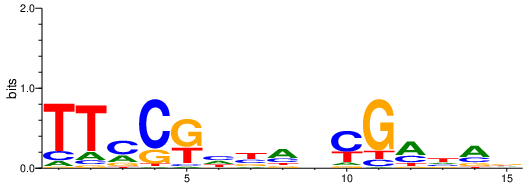

In [153]:
eu.pl.filter_viz(sdata_subset, filter_id=0)

---

# Scratch

In [ ]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
tm_r2score = R2Score()
print(tm_r2score(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.r2_score(y_true, y_pred))

sdata_train = sdata_subset[train_idx]
sdata_val = sdata_subset[val_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(tm_r2score(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.r2_score(uno_x, dos_x))

tensor(0.9486)
0.9486081370449679
tensor(-17.8863)
0.16492233358169228


In [ ]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
print(model.loss_fxn(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.mean_squared_error(y_true, y_pred))

sdata_train = sdata_subset[train_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(model.loss_fxn(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.mean_squared_error(uno_x, dos_x))

tensor(0.3750)
0.375
tensor(0.8351, dtype=torch.float64)
0.8350776664183077
